In [22]:
import matplotlib.colors as mcolors
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.ticker import FixedLocator
import pandas as pd
from scipy.fftpack import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt
import os



In [24]:
### Helper functions

def power_spectrum(t, x_array):
    """
    Compute and plot the power spectrum of a signal.
    
    Parameters:
    t: Array of time points.
    x_array: Array of signal values.
    """
    # Compute the Fast Fourier Transform (FFT) of the signal
    fft_vals = fft(x_array)

    # Compute the power spectral density (PSD)
    psd = np.abs(fft_vals) ** 2
    
    # normalize PSD
    psd = psd/max(psd)    

    # Get the frequencies corresponding to the values of the PSD
    fft_freq = fftfreq(len(psd), d=(t[1]-t[0]))
    
    # reset fundamental frequency at 1
    fft_freq = fft_freq * 2*np.pi    

    # Only keep the positive frequencies (the spectrum is symmetric)
    i = (fft_freq > 0) & (fft_freq < 100)    
    return (fft_freq[i], psd[i])

def figure_3_from_simulation(plot_data):
    
    ### get rid of transience, or first quarter of all time steps
    num_rows = len(plot_data)
    transient_rows = int(num_rows * 1/4)  # Compute the number of rows to keep
    plot_data = plot_data.iloc[transient_rows:]     

    t_array = plot_data["time"].tolist()
    df_PSD = pd.DataFrame()
    for column_name, series in plot_data.items():
        if "response_under" in column_name:
            x_array = series.tolist()
            fft_freq, psd = power_spectrum(t_array, x_array)
            df_PSD["PSD"+column_name[8:]] = psd
    df_PSD["freq"] = fft_freq

    fig, ax = plt.subplots(figsize = (8,10))
    x_rang = (0.2,32)
    y_rang = (0.05,100)

    # Create a colormap to colorize the lines
    cmap = plt.get_cmap('plasma_r')

    ### linear color map
    # norm = mcolors.Normalize(vmin=df_PSD.drop(columns='freq').values.min(), 
    #                          vmax=df_PSD.drop(columns='freq').values.max())

    ### log color map
    norm = colors.LogNorm(vmin=df_PSD.drop(columns='freq').values.min(), 
                          vmax=df_PSD.drop(columns='freq').values.max())

    ### plot guiding lines

    ax.plot(x_rang,x_rang, '--', c = 'black', lw = 0.5)
    ax.plot(x_rang,[1]*2, '-', c = 'black', lw = 0.5, alpha = 0.5)

    for column in df_PSD.columns:
        if column != 'freq':
            # Extract the driving frequency from the column name
            driving_freq = float(column.split('_')[-1])

            # plot guiding lines
            # ax.plot(x_rang,[driving_freq]*2, '-', c = 'black', lw = 0.5, alpha = 0.5)

            # Create a line plot for each column, colorize using the colormap        
            ax.scatter([driving_freq]*len(df_PSD['freq']), 
                        df_PSD['freq'], 
                        c=df_PSD[column],
                        cmap=cmap, norm=norm, 
                        marker = "_", lw = 3, s = 80)

    # Add a colorbar to show the scale for the PSD magnitude
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='power spectrum (normalized)')

    ax.set_xlabel('Driving frequency $f_d(24h)^{-1}$')
    ax.set_ylabel('Response frequency $f_r(24h)^{-1}$')
    ax.set_xscale("log")
    ax.set_yscale("log")

    ### Set the x and y labels
    x_ticks = np.arange(int(np.log2(x_rang[0])), int(np.log2(x_rang[1]))+1)
    y_ticks = np.arange(int(np.log2(y_rang[0])), int(np.log2(y_rang[1]))+1)

    ax.set_xticks(2.**x_ticks)
    ax.set_yticks(2.**y_ticks)

    ax.set_xticklabels(['$2^{'+str(int(i))+'}$' for i in x_ticks])
    ax.set_yticklabels(['$2^{'+str(int(i))+'}$' for i in y_ticks])
    ax.minorticks_off()


### Load data and generate figure 3

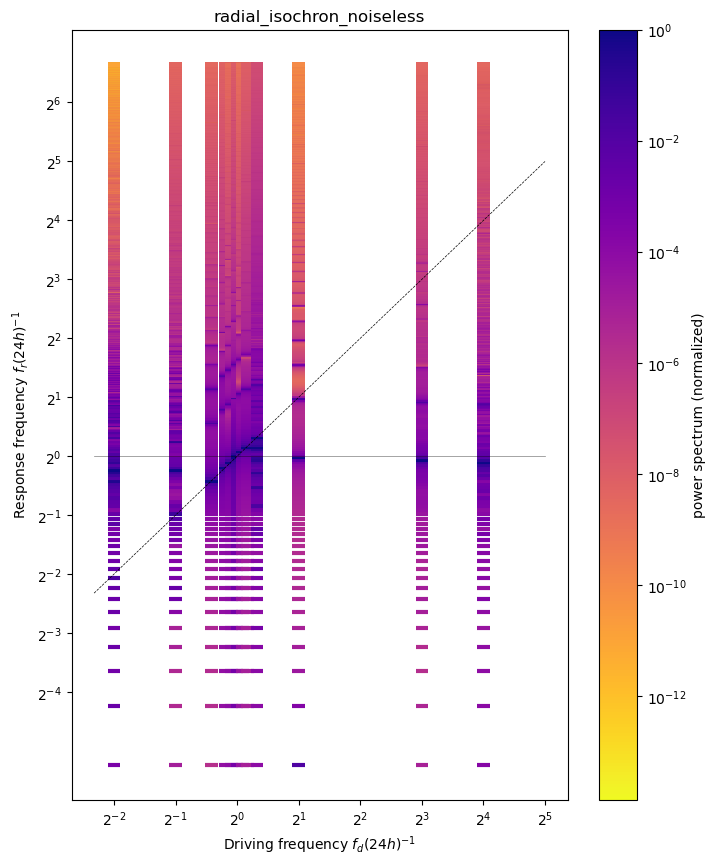

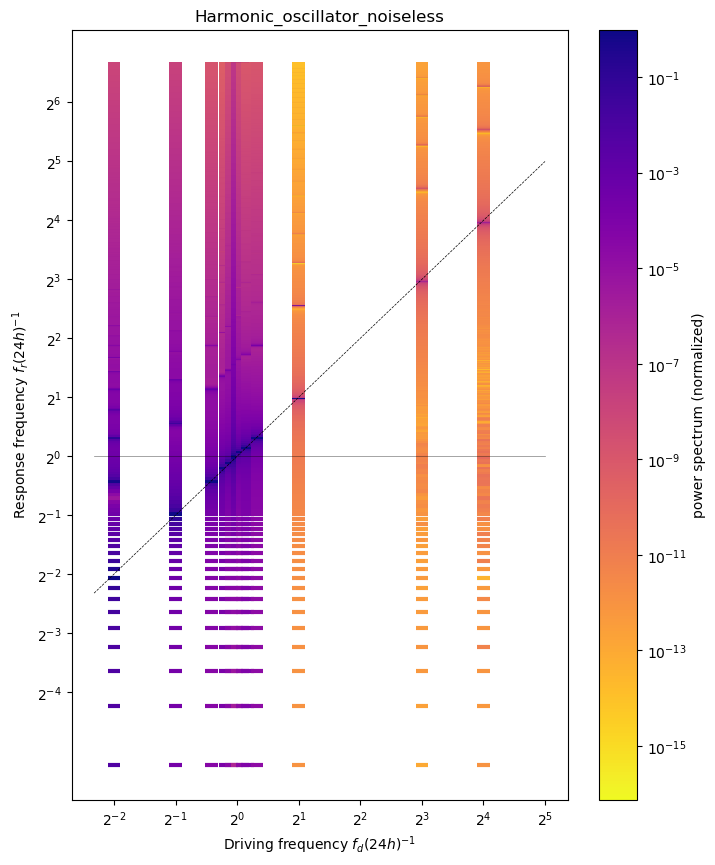

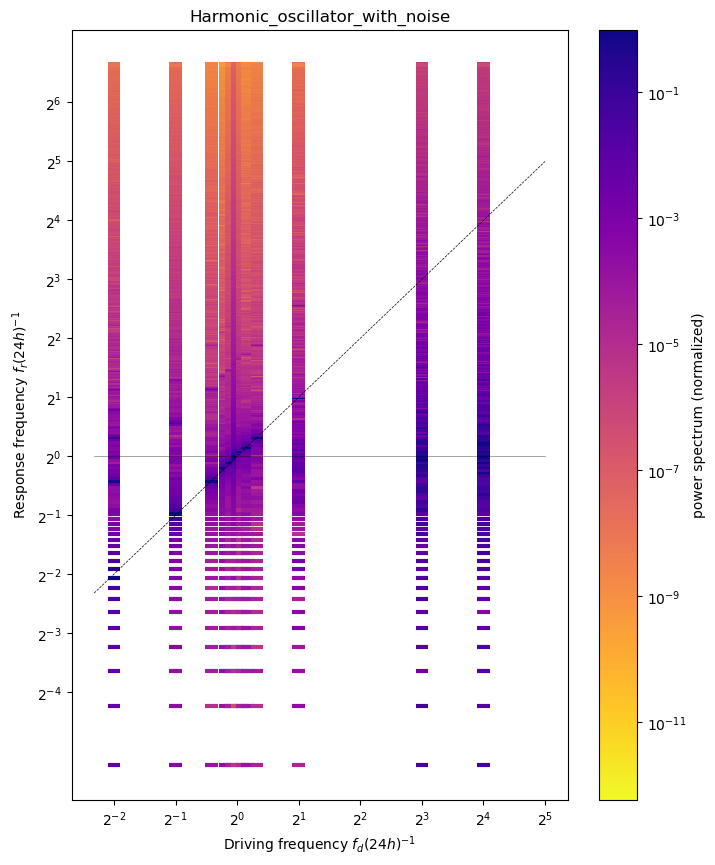

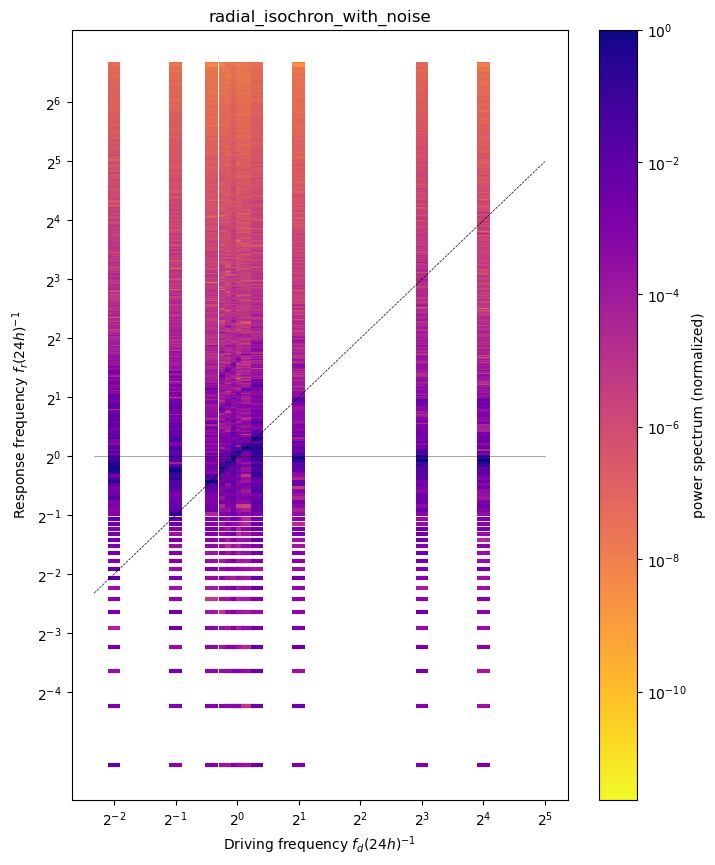

In [39]:
data_dir = 'simulated_data_high_res/'
plot_save_dir = 'figure3_simulated/'
for filename in os.listdir(data_dir):
    plot_name = filename[:-4]
    plot_data = pd.read_csv(os.path.join(data_dir, filename))
    figure_3_from_simulation(plot_data)
    plt.title(plot_name)
    plt.savefig(plot_save_dir+plot_name+".png", format = "png")

